### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [47]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
# import data handling class
from DT5550 import *
from scipy.special import legendre

# %load_ext snakeviz

Open a datafile and read the data

In [103]:
#
# open the datfile / data directory
#
    
#io = DT5550(indir='C:/data/20220112_105851/')
#io = DT5550(file='C:/data/20220110_165917/data_20220110_165917_24.raw')

#
# loop over all the events
#
dt_max = 10

Etot = []
Etot_sel = []
nhit_tag1173 = np.zeros(8)
nhit_tag1330 = np.zeros(8)
nhit_untag1173 = np.zeros(8)
nhit_untag1330 = np.zeros(8)
ee = []

#r = [[], [], [], [], [], [], [], []]
#for i in range(8):
#    r.append([])

nmax = 9999
nf = 0
idet_old = 0

# untagged
io = DT5550(indir='C:/data/20220112_105851/')

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:
        #
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        
        nh = io.valid.sum()
        
        # events with one or more hits
        if nh >= 1:
            for idet in range(8):                
                rr = io.R[idet]
                rmean = io.config['detector_settings'][idet]['RMEAN']
                rsig = io.config['detector_settings'][idet]['RSIGMA']
                if io.valid[idet] and io.Q[idet]>1100 and io.Q[idet]<1250: #and abs(rr-rmean)<2*rsig:
                    nhit_untag1173[idet] += 1
                if io.valid[idet] and io.Q[idet]>1250 and io.Q[idet]<1450: #and abs(rr-rmean)<2*rsig:
                    nhit_untag1330[idet] += 1

                    #idet_old = idet

print('Processing done')

# tagged
io = DT5550(indir='C:/data/20220110_165917/')

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:   
        nh = io.valid.sum()

        # events with two hits
        if nh == 2:
            id_sel = []
            for idet in range(8):
                if io.valid[idet]:
                    id_sel.append(idet)
                    
            id0 = id_sel[0]
            id1 = id_sel[1]
            #  the total measured energy
            Etot.append(io.Q.sum()) 
            
            delta_t = io.tc[id1] - io.tc[id0]
            if id0 == 0:
                if abs(delta_t) < dt_max:
                    Esum = io.Q[id0] + io.Q[id1]
                    Etot_sel.append(Esum)
                    if io.Q[id0]>1250 and io.Q[id0]<1450 and io.Q[id1]>1100 and io.Q[id1]<1250:
                        nhit_tag1173[id1] += 1
                    if io.Q[id0]>1100 and io.Q[id0]<1250 and io.Q[id1]>1250 and io.Q[id1]<1450:
                        nhit_tag1330[id1] += 1
                

print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
ee = np.array(ee)
#r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220112_105851\config_20220112_105851.json
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_0.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_1.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_2.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_3.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_4.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_5.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_6.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_7.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_8.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_9.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_10.raw
DT5550:: Open data file: C:/data/20220112_105851\data_20220112_105851_11.r

A few basic plots: integrated charge and time

In [94]:
#io.plot_all(type="charge",bins=50,logy=False, range=(1000,1500))

In [95]:
#io.plot_all(type="time",range=(0,250),bins=100,logy=True)

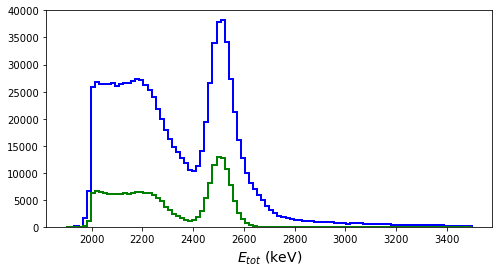

In [96]:
plt.figure(figsize=(8,4))

plot_range=(1900,3500)
plt.hist(Etot, bins=100, range=plot_range, histtype='step', color='blue', linewidth=2)
plt.hist(Etot_sel, bins=100, range=plot_range, histtype='step', color='green', linewidth=2)

plt.xlabel('$E_{tot}$ (keV)', fontsize=14)
plt.yscale('linear')

In [97]:
def legendre_polynomial(x,a,b,c):
    P0 = legendre(0)
    P2 = legendre(2)
    P4 = legendre(4)
    return a*(P0(x) + b*P2(x) + c*P4(x))

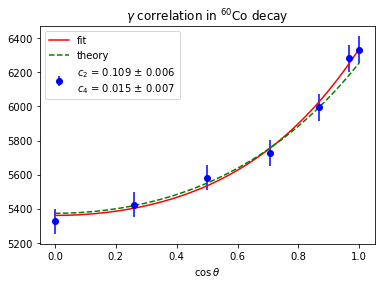

In [160]:
import lmfit as lm

x = np.arange(1,8,1)
theta = (7-x)*(np.pi/12)+np.pi/2
cost = abs(np.cos(theta))

data = nhit_tag1330[1:8]
#data = nhit_tag1173[1:8]

#corr = (nhit_untag1173[1:8]+nhit_untag1330[1:8])
#corr = nhit_untag1330[1:8]
corr = np.ones(7)
y =  data / corr
yerr = np.sqrt(data)/ corr
#print(x,cost,yerr)

model = lm.model.Model(legendre_polynomial)
params = lm.Parameters()
params.add("a", value = 0.1)
params.add("b",value = 0.1)
params.add("c", value = 0.01)
fit = model.fit(y, x=cost, weights = [1/element for element in yerr], params = params)

a = fit.params["a"].value
b = fit.params["b"].value
c = fit.params["c"].value
a_err = fit.params["a"].stderr
b_err = fit.params["b"].stderr
c_err = fit.params["c"].stderr
xx = np.linspace(0.,1.,100)
#yy = a*(P0(xx) + b*P2(xx) + c*P4(xx))
#a = 0.03
#b = 0.1005
#c = 0.0094 
txt = '$c_2$ = {:4.3f} $\pm$ {:4.3f} \n$c_4$ = {:4.3f} $\pm$ {:4.3f}'.format(b,b_err,c,c_err)
h = plt.errorbar(cost, y, yerr=yerr, fmt = 'o', color='blue', label=txt)
plt.plot(xx, legendre_polynomial(xx, a, b, c),'-',color='red', label='fit')
plt.plot(xx, legendre_polynomial(xx, a, 0.1005, 0.0094), '--', color='green', label='theory' )
plt.xlabel('$\cos \\theta$')
plt.legend()
plt.title("$\gamma$ correlation in $^{60}$Co decay")

plt.show()

C:\Users\admlab\AppData\Local\Temp/ipykernel_12752/1183286640.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.errorbar(cost, y, yerr=yerr, marker='o', fmt='.')


Text(0.5, 1.0, 'Theoriecurve met meetpunten')

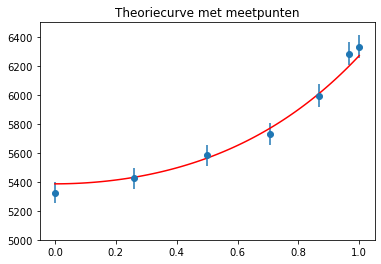

In [102]:
x = np.arange(0,8,1)
theta = (7-x)*(np.pi/12)+np.pi/2
cost = abs(np.cos(theta))

y = nhit_tag
yerr= np.sqrt(y)
plt.errorbar(cost, y, yerr=yerr, marker='o', fmt='.')
plt.ylim([5000,6500])
P0 = legendre(0)
P2 = legendre(2)
P4 = legendre(4) 
xx = np.linspace(0,1,100)
yy = 5650*(P0(xx) + 0.1005*P2(xx) + 0.0094*P4(xx))

plt.plot(xx,yy,'-',color='red')
plt.title("Theoriecurve met meetpunten")

(150000.0, 250000.0)

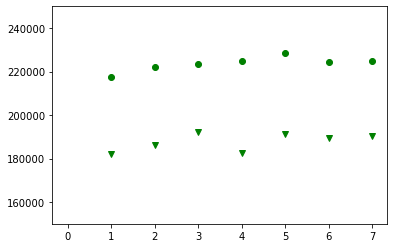

In [127]:
plt.plot(nhit_untag1330,'v', color='green')
plt.plot(nhit_untag1173,'o', color='green')

#plt.plot(nhit_tag,'o',color='blue')
plt.ylim([150000.,250000.])

In [ ]:
np.sqrt(18000)

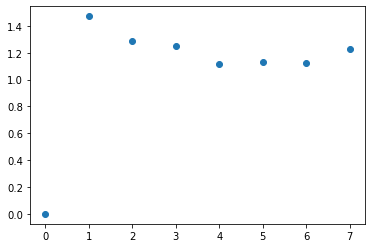

In [91]:
plt.plot(nhit_tag/nhit_untag,'o')
#plt.ylim([0.025,0.04])

In [ ]:
nhit_tag

{'version': 'Rev.C',
 'source': 'Co60',
 'comment': 'just work and no play makes AP a bad boy',
 'registers': {'V_max': 1.8,
  'nbit_adc': 14,
  'V_offset': 0.9,
  'Termination': 0,
  'INTTIME': 200,
  'PREINIT': 15,
  'BLLEN': 8,
  'BLHOLD': 300,
  'WINDOW': 350,
  'TMODE': 0,
  'NMIN': 1,
  'EMIN': 2000},
 'detector_settings': [{'det_id': 0,
   'GAIN': 1925,
   'THRS': 50,
   'INVERT': 1,
   'BASE': 408,
   'TOFF': 0,
   'HV': 500,
   'GCOR': 0.9971626473700236,
   'RMEAN': 1228.5257188170874,
   'RSIGMA': 14.790841337774614},
  {'det_id': 1,
   'GAIN': 2098,
   'THRS': 50,
   'INVERT': 1,
   'BASE': 669,
   'TOFF': 5,
   'HV': 460,
   'GCOR': 0.9964511655236329,
   'RMEAN': 1262.7022576456782,
   'RSIGMA': 17.204479164288443},
  {'det_id': 2,
   'GAIN': 1953,
   'THRS': 50,
   'INVERT': 1,
   'BASE': 351,
   'TOFF': -13,
   'HV': 780,
   'GCOR': 0.9998271058866147,
   'RMEAN': 1264.8941724404026,
   'RSIGMA': 15.525182599268952},
  {'det_id': 3,
   'GAIN': 1773,
   'THRS': 50,
   'I